# Zombies Spread Dynamics
Simulation of the spread of a zombie epidemic in Europe, based on the modeling of the territory with graph theory, in order to take control measures with military troops and nuclear bombs to save the largest possible population. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os, tqdm
import datetime as dt
import networkx as nx
import matplotlib.pyplot as plt

from libraries.dynamics import spread_zombie_dynamics as szd
from libraries.dynamics import graph_by_default

## Network reading
After executing the notebook [graph construction](https://github.com/TEAM-IMT/zombies-spread-dynamics/blob/main/Codes/Challenge_2_graphconstruction.ipynb), the file **All_nodes_graph.gexf** will be generated. For convenience, we provide this file in zip format. The file is then unzipped.

In [2]:
graph_zip = './graph/without_see_nodes_graph_ini_2.zip'
graph_path = graph_zip.replace('.zip','.gexf')
if not os.path.isfile(graph_path):
    if not os.path.isdir('graph'): os.mkdir('graph')
    !unzip $graph_zip -d "./graph"
print('[INFO] File unzip successfully.')

[INFO] File unzip successfully.


## Epidemic spread
As a first view, let's load the network and see the initial state of the two populations

In [3]:
graph_path = './graph/without_see_nodes_graph_ini_2.gexf'
G = nx.readwrite.gexf.read_gexf(graph_path)
ini_date = dt.datetime(year = 2019, month = 8, day = 18)

In [4]:
dynamic = szd(graph = G, INTIAL_DATE = ini_date)
dynamic.graph_pos = {G.nodes[n]['node_id']:(eval(n)[1],-eval(n)[0]) for n in G.nodes()}

[INFO] Graph was modified ...


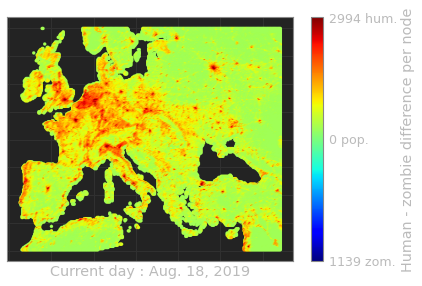

<AxesSubplot:xlabel='Current day : Aug. 18, 2019'>

In [5]:
dynamic.plot_graph()

Now, let's see how it evolves over time, over the course of two months.

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (20,15))
ax_info = {
    "18-08-2019": axs[0,0], "20-08-2019": axs[0,1],
    "22-08-2019": axs[1,0], "03-10-2019": axs[1,1],
}
dynamic.reset()
for epoch in tqdm.tqdm(range(61)): # 2 months
    current_date = "{0:%d-%m-%Y}".format(dynamic.current_date)
    if current_date in ax_info.keys():
        dynamic.plot_graph(ax = ax_info[current_date])
        dynamic.save_checkpoint()
        if current_date == "03-10-2019": break
    print(dynamic) # See basic statistics at each iteration
    dynamic.step() # Run one step in dynamic procedure